In [163]:
import chi

In [164]:
chi.set('project_name', 'CHI-221015')
chi.use_site('CHI@TACC')

Now using CHI@TACC:
URL: https://chi.tacc.chameleoncloud.org
Location: Austin, Texas, USA
Support contact: help@chameleoncloud.org


In [183]:
import chi.lease

# Reserve 1 compute nodes
compute_node_reservation_list_1 = []
chi.lease.add_node_reservation(compute_node_reservation_list_1, resource_properties = ['==', '$node_name', 'c11-23'], count=1)
compute_lease_1 = chi.lease.create_lease("my-indyscc-compute-node-lease_2_1", reservations=compute_node_reservation_list_1)

# Reserve 1 compute nodes
compute_node_reservation_list_2 = []
chi.lease.add_node_reservation(compute_node_reservation_list_2, resource_properties = ['==', '$node_name', 'c11-24'], count=1)
compute_lease_2 = chi.lease.create_lease("my-indyscc-compute-node-lease_2_2", reservations=compute_node_reservation_list_2)

print("see https://chi.rcac.purdue.edu/project/leases/ for current lease status")
# wait for lease to become active
compute_lease_1 = chi.lease.wait_for_active(compute_lease_1['id'])  # Ensure lease has started
compute_lease_2 = chi.lease.wait_for_active(compute_lease_2['id'])  # Ensure lease has started

see https://chi.rcac.purdue.edu/project/leases/ for current lease status


In [184]:
import chi.server

# Launch your compute node instances
compute_node_1 = chi.server.create_server(
    "indyscc-compute-node_2_1",                                 
    reservation_id=chi.lease.get_node_reservation(compute_lease_1["id"]),
    image_name='indyscc-head-node_f77c87af-89b0-4938-be78-7156d3297ae2',
    network_name="polo_test-isolated_net-vxsdpigdsmu4",
    count=1)

# Launch your compute node instances
compute_node_2 = chi.server.create_server(
    "indyscc-compute-node_2_2",                                 
    reservation_id=chi.lease.get_node_reservation(compute_lease_2["id"]),
    image_name='indyscc-head-node_f77c87af-89b0-4938-be78-7156d3297ae2',
    network_name="polo_test-isolated_net-vxsdpigdsmu4",
    count=1)

In [186]:
# wait for nodes to become active. This can take 10-20 minutes, as they need to reboot twice.
# you can run this again if it times out.
print(f"Waiting for instances to become active. Check out the current status at https://chi.rcac.purdue.edu/project/instances/")

compute_node_start_1 = chi.server.wait_for_active(compute_node_1.id)
compute_node_start_2 = chi.server.wait_for_active(compute_node_2.id)

Waiting for instances to become active. Check out the current status at https://chi.rcac.purdue.edu/project/instances/


In [189]:
from chi.ssh import Remote
# Assign a public floating IP
ip_1 = chi.server.associate_floating_ip(compute_node_1.id)
ip_2 = chi.server.associate_floating_ip(compute_node_2.id)

In [190]:
# Create a remote connection
c1_remote = Remote(ip_1)
c2_remote = Remote(ip_2)

In [191]:
# Run some commands on your remote server
cpu_usage = c1_remote.run("grep 'cpu ' /proc/stat | awk '{usage=($2+$4)*100/($2+$4+$5)} END {print usage}'", hide=True)

print('Current CPU usage is {}%'.format(float(cpu_usage.stdout)))

# Run some commands on your remote server
cpu_usage = c1_remote.run("grep 'cpu ' /proc/stat | awk '{usage=($2+$4)*100/($2+$4+$5)} END {print usage}'", hide=True)

print('Current CPU usage is {}%'.format(float(cpu_usage.stdout)))

/opt/conda/lib/python3.9/site-packages/paramiko/client.py:835: UserWarning: Unknown ssh-ed25519 host key for 129.114.108.200: b'c81e39f03f4381ec80fdd109c3974d23'
  warnings.warn(


Current CPU usage is 0.0898412%
Current CPU usage is 0.0898454%


In [192]:
print(ip_1, ip_2)

129.114.108.200 129.114.109.80


In [219]:
c1_remote.run("nohup iperf3 -s -p 9898 >> /tmp/listen.txt 2>&1 &")

<Result cmd='nohup iperf3 -s -p 9898 >> /tmp/listen.txt 2>&1 &' exited=0>

In [218]:
c1_remote.run("killall iperf3")

iperf3: no process found


UnexpectedExit: Encountered a bad command exit code!

Command: 'killall iperf3'

Exit code: 1

Stdout: already printed

Stderr: already printed



In [194]:
c1_remote.run("ip a")

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: eno1: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 44:a8:42:26:64:99 brd ff:ff:ff:ff:ff:ff
    inet 192.168.8.192/24 brd 192.168.8.255 scope global dynamic eno1
       valid_lft 83702sec preferred_lft 83702sec
    inet6 fe80::46a8:42ff:fe26:6499/64 scope link 
       valid_lft forever preferred_lft forever
3: eno2: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 44:a8:42:26:64:9b brd ff:ff:ff:ff:ff:ff
    inet6 fe80::46a8:42ff:fe26:649b/64 scope link 
       valid_lft forever preferred_lft forever
4: eno3: <NO-CARRIER,BROADCAST,MULTICAST,UP> mtu 1500 qdisc mq state DOWN grou

<Result cmd='ip a' exited=0>

In [220]:
c2_remote.run("iperf3 -J -t 60 -i 1 -A 1 -c 192.168.8.192 -p 9898 > /tmp/perf.json")

<Result cmd='iperf3 -J -t 60 -i 1 -A 1 -c 192.168.8.192 -p 9898 > /tmp/perf.json' exited=0>

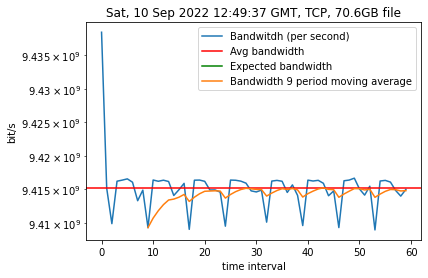

In [226]:
import json
import matplotlib.pyplot as plt
import sys
import argparse


def ema(data, window):
    if len(data) < window + 2:
        return None
    alpha = 2 / float(window + 1)
    ema = []
    for i in range(0, window):
        ema.append(None)
    ema.append(data[window])
    for i in range(window+1, len(data)):
        ema.append(ema[i-1] + alpha*(data[i]-ema[i-1]))
    return ema


def chart(args, data):
    # Setting the default values
    expected_bandwidth = 0
    ema_window = 9
    if args.protocol == 'udp':
        sum_string = 'sum'
    else:
        sum_string = 'sum_sent'
    if args.ema is not None:
        ema_window = int(args.ema)
    if args.expectedbw is not None:
        expected_bandwidth = int(args.expectedbw)

    debit = []
    intervals = data['intervals']
    for i in intervals:
        debit.append(i['sum']['bits_per_second'])

    plt.plot(debit, label='Bandwitdh (per second)')

    plt.axhline(data['end'][sum_string]['bits_per_second'], color='r', label='Avg bandwidth')
    plt.axhline(expected_bandwidth * 1000000, color='g', label='Expected bandwidth')
    plt.plot(ema(debit, ema_window), label='Bandwidth {} period moving average'.format(ema_window))

    plt.title('{}, {}, {:.3}GB file'.format(data['start']['timestamp']['time'],
                                         data['start']['test_start']['protocol'],
                                         data['end'][sum_string]['bytes']/1000000000))
    plt.legend()
    if args.log:
        plt.yscale('log')
    else:
        plt.yscale('linear')
        plt.ylim(bottom=0)
    plt.ylabel('bit/s')
    plt.xlabel('time interval')
    plt.savefig('a2_c1_c2_1.png')
    plt.show()
    


def be_verbose(args, data):
    print('Version 1.0 - Feb 2019')
    print('Command arguments are {}'.format(args))
    print('Start info : {}'.format(data['start']))
    print('End info : {}'.format(data['end']))


def main(argv):
    parser = argparse.ArgumentParser(description='Simple python iperf JSON data vizualiser. Use -J option with iperf to have a JSON output.')
    parser.add_argument('input', nargs='?', help='JSON output file from iperf')
    parser.add_argument('-a', '--ema', help='Exponential moving average used to smooth the bandwidth. Default at 9.', type=int)
    parser.add_argument('-e', '--expectedbw', help='Expected bandwidth to be plotted in Mb.')
    parser.add_argument('-v', '--verbose', help='Increase output verbosity', action='store_true')
    parser.add_argument('-l', '--log', help='Plot will be in logarithmic scale', action='store_true')
    args = parser.parse_args(argv)
    with open(args.input) as f:
        data = json.load(f)
        if args.verbose:
            be_verbose(args, data)
        if data['start']['test_start']['protocol'] == 'UDP':
            args.protocol = 'udp'
        else:
            args.protocol = 'tcp'
        chart(args, data)


if __name__ == '__main__':
    argv = sys.argv[2:]
    argv[0] = '-l'
    argv.append('/work/a2_c1_c2_1.json')
    main(argv)